# Контуры и ориентация
Используем выделенные границы, чтобы найти контуры объекта, исправим его ориентацию и вырежем объект для анализа.

Изображение: https://video.ittensive.com/machine-vision/barcode.example.png

### Подключение библиотек

In [1]:
%matplotlib inline
import numpy as np
import cv2
import os, os.path
import matplotlib.pyplot as plt

### Выделение контуров
Предварительная фильтрация + Канни

In [2]:
def show_image (image):
    plt.figure(figsize=(16,8))
    plt.imshow(np.uint8(np.absolute(image)))
    plt.show()

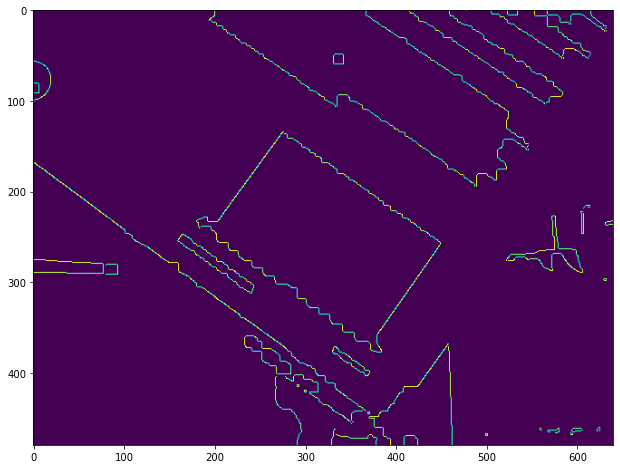

In [3]:
image = cv2.imread("barcode.example.png")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
otsu, image_thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
image_open = cv2.morphologyEx(image_thresh, cv2.MORPH_OPEN, np.ones((3,3)), iterations = 5)
image_canny = cv2.Canny(image_open, otsu/2, otsu)
show_image(image_canny)

### Обнаружение контуров
Выделим максимальный закрытый контур из границ Канни

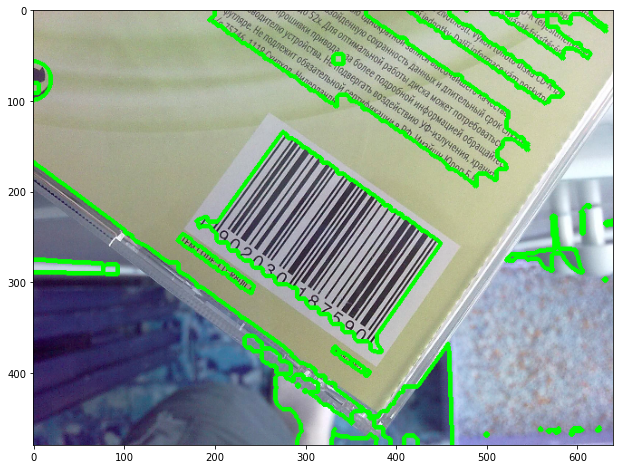

In [4]:
contours, hierarchy = cv2.findContours(image_canny,
                                       cv2.RETR_LIST,
                                       cv2.CHAIN_APPROX_SIMPLE)
show_image(cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3))

Максимальный ограничивающий прямоугольник. Отбрасываем границы изображения, добавляем отступ.

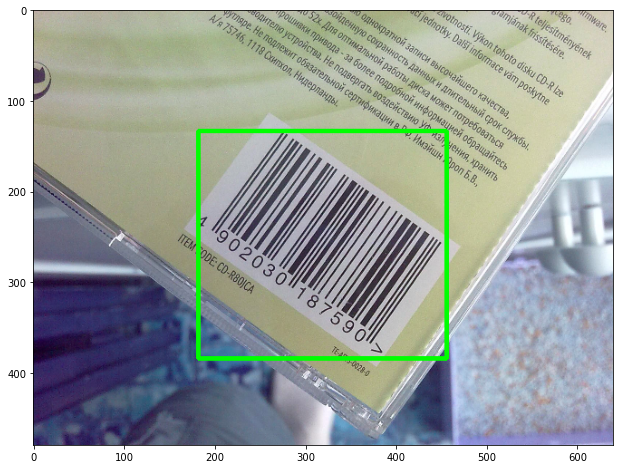

In [5]:
max_square = 0
border = 3
(start_point, end_point) = ((0,0), (0,0))
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w*h > max_square and x>0 and y>0:
        start_point = (x-border, y-border)
        end_point = (x+w+2*border, y+h+2*border)
        max_square = w*h
show_image(cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 3))

### Авто-поворот изображения
Используем прямоугольную форму штрихкода: вычислим вписывающий прямоугольник и определим его поворот

Угловой коэффициент: k = (y1 - y2) / (x1 - x2)

((500.0, 468.00006103515625), (1.4142134189605713, 1.4142134189605713), -45.0)
((600.0, 463.0), (12.0, 4.0), -0.0)
((573.8359985351562, 464.3479919433594), (13.326967239379883, 4.740464687347412), -10.304845809936523)
((355.19671630859375, 444.83599853515625), (15.620499610900879, 5.633622646331787), -39.80556869506836)
((317.8981018066406, 423.4889221191406), (16.36813735961914, 87.65515899658203), -54.72757339477539)
((202.13583374023438, 279.6329345703125), (11.934793472290039, 100.9619140625), -53.746158599853516)
((323.520263671875, 253.37164306640625), (143.2170867919922, 242.14382934570312), -54.46232223510742)
[[380 382]
 [183 241]
 [266 124]
 [463 265]]


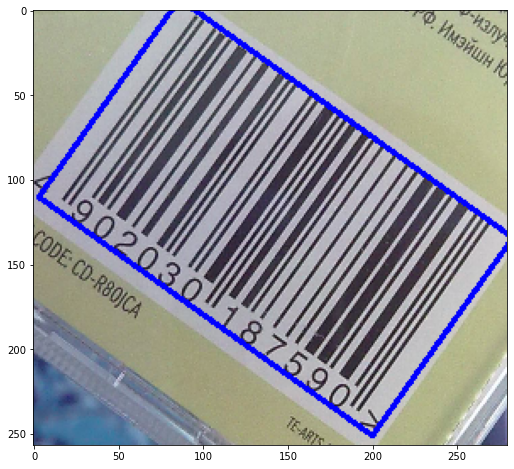

In [6]:
max_square = 0
border = 5
(start_point, end_point) = ((0,0), (0,0))
img = image.copy()
for cnt in contours:
    x,y,w,h = cv2.boundingRect(cnt)
    if w*h > max_square and x>border and y>border and x+w<len(image[0])-border and y+h<len(image)-border:
        start_point = (x-border, y-border)
        end_point = (x+w+2*border, y+h+2*border)
        max_square = w*h
        rect = cv2.minAreaRect(cnt)
        box = np.int0(cv2.boxPoints(rect))
        print (rect)
cv2.drawContours(img, [box], 0, (0,0,255), 2)
print (box)
barcode = img[start_point[1]:end_point[1], start_point[0]:end_point[0]]
show_image(barcode)

Создадим матрицу поворота и повернем изображение на вычисленный угол в тех же размерах

In [7]:
angle = rect[-1]
if angle < 0:
    angle = 180 + angle
if angle > 90:
    angle = angle - 90
print ("Градус поворота, градусы:", angle)

Градус поворота, градусы: 35.53767776489258


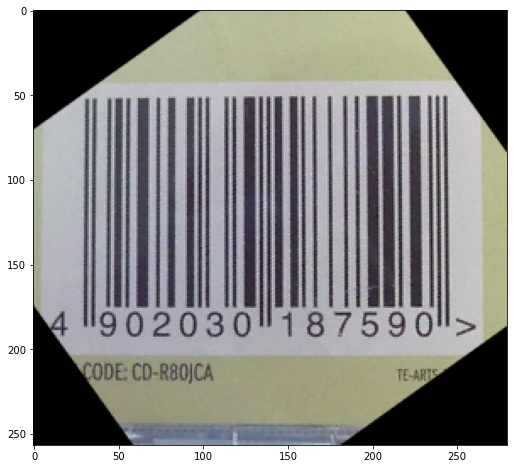

In [8]:
barcode = image[start_point[1]:end_point[1], start_point[0]:end_point[0]]
cols = len(barcode[0])
rows = len(barcode)
rotation = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
barcode_rotated = cv2.warpAffine(barcode, rotation, (cols, rows))
show_image(barcode_rotated)

Вырежем из повернутого изображения нужные размеры

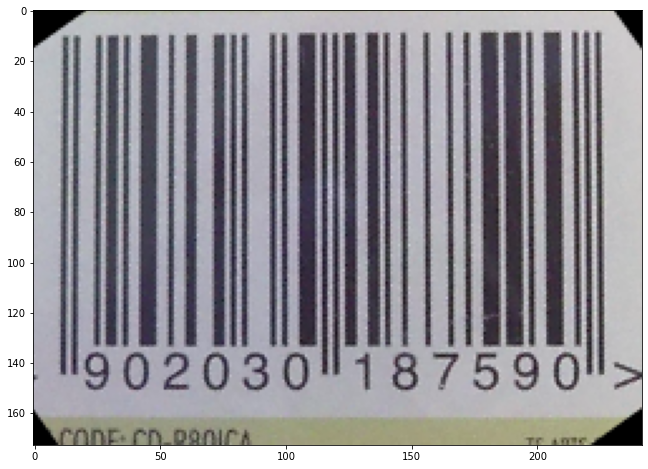

In [9]:
new_cols = np.abs(int((box[0][0] - box[1][0])/np.cos(angle*np.pi/180)))
new_rows = np.abs(int((box[0][1] - box[1][1])/np.cos(angle*np.pi/180)))
new_x = int((cols-new_cols)/2)
new_y = int((rows-new_rows)/2)
barcode_cropped = barcode_rotated[new_y:new_y+new_rows, new_x:new_x+new_cols]
show_image(barcode_cropped)